In [1]:
# sys, file and nav packages:
import datetime as dt

# math packages:
import pandas as pd
import numpy as np
import math

# charting:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker
from matplotlib.gridspec import GridSpec
import seaborn as sns

# home brew utitilties
import utilities.utility_functions as ut
import utilities.abundance_classes as ac
import utilities.chart_kwargs as ck

import utilities.sr_ut as sut

# images and display
import base64, io, IPython
from PIL import Image as PILImage
from IPython.display import Markdown as md

# data sources
data_sources = {    
    "survey_data":"results_with_zeroes.csv",
    "river_bassins":"river_basins.json",
    "beaches":"beaches_with_gis.csv",
    "codes":"mlw_codes.csv",
    "code_groups":"code_group2.json",
    "dims_data":"dims_data.csv"
}

# set some parameters:
today = dt.datetime.now().date().strftime("%Y-%m-%d")
start_date = '2020-01-01'
end_date =today

# name of the output folder:
name_of_project = 'site_report_biel'

# set the maps
bassin_map = PILImage.open("resources/maps/aare_scaled_small.jpeg")
city_map = PILImage.open("resources/maps/biel_scaled.jpeg")

# these pick your aggregation set

# the city, lake and river bassin we are aggregating to
# the keys are column names in the survey data


# levels = {"city":"Saint-Gingolp","water_name_slug":'lac-leman', "river_bassin":'rhone'}
# level_names = [levels['city'],"Lac Léman","Rhône bassin"]


# La Tour-de-Peilz
# levels = {"city":"Vevey","water_name_slug":'lac-leman', "river_bassin":'rhone'}
# level_names = [levels['city'],"Lac Léman","Rhône bassin"]

# levels = {"city":"La Tour-de-Peilz","water_name_slug":'lac-leman', "river_bassin":'rhone'}
# level_names = [levels['city'],"Lac Léman","Rhône basin"]

# levels = {"city":"Burgdorf","water_name_slug":'emme', "river_bassin":'aare'}
levels = {"city":"Biel/Bienne","water_name_slug":'bielersee', "river_bassin":'aare'}

# levels = {"city":"Bern","water_name_slug":'aare', "river_bassin":'aare'}
level_names = [levels['city'], "Bielersee","Aare basin"]


# variables for the directory tree
most_recent, survey_data, location_data, code_defs, stat_ent, geo_data, output = ut.make_local_paths()

# add the folder to the directory tree:
project_directory = ut.make_project_folder(output, name_of_project)

# keep track of output
files_generated = []
figure_num = 0
data_num = 0

# define the methods to handle the data .JSON or .csv:
my_data_methods = {'json':ut.json_file_get, 'csv':pd.read_csv}

# get your data:
survey_data, river_bassins, dfBeaches, dfCodes, code_groups, dfDims = sut.get_data_from_most_recent(data_sources, data_methods=my_data_methods)

def add_output(**kwargs):
    files_generated.append({'tag':kwargs['tag'], 'number':kwargs['figure_num'], 'file':kwargs['file'],'type':kwargs['a_type']})
    if kwargs['a_type'] == 'data':
        kwargs['data'].to_csv(F"{kwargs['file']}.csv", index=False)
    else:
        plt.savefig(F"{kwargs['file']}.jpeg", dpi=300)

In [2]:
#help(sut)

In [3]:
md(F"## <span style='color:#008891'>Municipal survey results: {levels['city']}</span>")

## <span style='color:#008891'>Municipal survey results: Biel/Bienne</span>

<a id='top'></a>
#### <span style="color:#008891">Identification, quantification and analysis of observable anthropogenic debris along swiss river and lakes (IQASL)</span>

IQASL is a project sponosred by the Swiss Federal Office for the environment to quantify shoreline trash along swiss lakes and rivers in the Rhone, Aare, Ticino and Linth/Limmat catchment areas. This is accomplished by conducting multiple small scale and discrete **litter surveys** throughout the river bassin. The majority of samples are taken from lakes.

#### <span style="color:#008891">What is a litter survey?</span>

A litter survey is the identification and count of all objects found within a delimited area bordered on one side by water. Each object is placed into one of 260 categories¹. The location, date, survey dimensions and the total number of objects in each category is noted.

The survey results are presented as a ratio of the number of objects found for each meter of shoreline surveyed. This allows us to compare surveys of different sizes.

#### <span style="color:#008891">Purpose of the surveys</span>

The survey results help ALL stakeholders identify the items that make up the mass of trash found in the natural environment on the shores of Swiss lakes and rivers. The surveys answer the following questions:

1. What items are found?
2. How much is found ? (total weights and item counts)
3. How often are these items found?
4. Where do you find the most?

These are the most frequently asked questions and should be considered when determining any mitigation or reduction strategies.

The project is based on the following assumptions:

1. The more trash there is on the ground the more a person is likely to find
2. The survey results represent the minimum amount of trash at that site²
3. For each survey: finding one item does not effect the chance of finding another³

#### <span style="color:#008891">Purpose of this report</span>

Summarize the survey results for the municpaility and define the magnitude of those results with respect to other locations in the river bassin and the aggregated national results.

#### <span style="color:#008891">Contents of this report</span>

1. [Description of river basin](#scope)
2. [Survey dimensions, locations, aggreagted totals](#communesummary)
3. [Trash removed: material type and usage](#matanduse)
4. [Trash removed: combined top ten](#combinedtopten)
5. [Trash removed the most often](#frequency)
6. [Annex](#annex): Survey location details, itemized list of objects removed


#### <span style="color:#008891">More information </span>

For more information about the project visit [project home](https://www.plagespropres.ch/).

If you would like your municipality to be surveyed on a regular basis contact:

1. Swiss federal office for the environment - Municipal waste section
2. hammerdirt

¹ [The EU guide on monitoring marine litter](https://mcc.jrc.ec.europa.eu/documents/201702074014.pdf)<br> ² There is most likely more trash at the survey site, but certainly not less than what was recorded.<br>³ Independent observations : [stats stackexchange](https://stats.stackexchange.com/questions/116355/what-does-independent-observations-mean)

In [4]:


# format the date to timestamp and slice the data by start/end date
dfSurveys = sut.fo_rmat_and_slice_date(survey_data.copy(), a_format="%Y-%m-%d", start_date=start_date, end_date=end_date)

# add the grouping column defined by river_bassins
data = sut.add_a_grouping_column(dfSurveys, river_bassins, column_to_match="water_name_slug")

# set the index of the beach data to location slug
dfBeaches.set_index('slug', inplace=True)

# set the index of dfCodes to code:
dfCodes.set_index('code', inplace=True)

# Create new codes to aggregate the EPS pieces and the Plastic pieces
a_foam_code = dfCodes.loc['G82'].copy()
a_foam_code['description'] = 'expanded polystyrene'
dfCodes.loc['Gfoam'] = a_foam_code

a_plastic_code = dfCodes.loc['G79'].copy()
a_plastic_code['description'] = 'Fragmented plastics'
dfCodes.loc['Gfrags'] = a_plastic_code

# these codes have long descriptions, they are abbreviated for display
dfCodes.loc['G74', 'description'] = "Foams not expanded polystyrene"
dfCodes.loc['G940', 'description'] = "Foamed EVA for crafts and sports"
dfCodes.loc['G96', 'description'] = 'Sanitary-pads/panty liners/tampons'

# make a map to the code descriptions
code_description_map = dfCodes.description

# make a map to the code descriptions
code_material_map = dfCodes.material

# put the data into a class
# kwargs for the abundance class
a_class_kwargs = dict(
    code_group_data=code_groups,
    levels=['river_bassin', 'water_name_slug', 'city'],
    river_bassins=river_bassins,
    exp_variables=['population','buildings', 'streets', 'intersects'],       
    code_group_loc=output,    
)

# the data labled by river bassin, water feature, city and beach name with independent variables attached
a = sut.SurveyData(data,  dfBeaches, these_cols=['loc_date', 'location', 'water_name_slug','date'], **a_class_kwargs)

# define the final data set here:
a_data = a.survey_data.copy()

# Combine the different sizes of fragmented plastics and styrofoam

# the codes for the foams
foam_sums = a_data[a_data.code.isin(['G81', 'G82', 'G83'])].groupby('loc_date', as_index=False).agg({'quantity':'sum', 'pcs_m':'sum'})

# the codes for the fragmented plastics
plast_sums = a_data[a_data.groupname == 'plastic pieces'].groupby('loc_date', as_index=False).agg({'quantity':'sum', 'pcs_m':'sum'})                                  

# aggregate and assign a new code for the values:
foamsurveys = foam_sums.loc_date.unique()
foamrows = []
for adate in foamsurveys:
    gx = a_data[(a_data.loc_date == adate)&(a_data.code=='G82')].copy()
    gx['code'] = 'Gfoam'
    gx['quantity'] = foam_sums[foam_sums.loc_date == adate].quantity
    gx['pcs_m'] = foam_sums[foam_sums.loc_date == adate].pcs_m
    foamrows.append(gx)

# create a data frame with the new values
the_foam_rows = pd.concat(foamrows)

# repeat for for plastics
plastsurveys = plast_sums.loc_date.unique()
plastrows = []
for adate in plastsurveys:
    gx = a_data[(a_data.loc_date == adate)&(a_data.code=='G79')].copy()
    gx['code'] = 'Gfrags'
    
    gx['quantity'] =plast_sums[plast_sums.loc_date == adate].quantity.values[0]
    gx['pcs_m'] = plast_sums[plast_sums.loc_date == adate].pcs_m.values[0]
    plastrows.append(gx)

the_plast_rows = these = pd.concat(plastrows)

# remove the orginal foam codes from the a_data
som_data = a_data[~a_data.code.isin(['G81', 'G82', 'G83'])].copy()

# use the fragmented plastics groupname to remove all those codes
som_data = som_data[som_data.groupname != 'plastic pieces'].copy()

# append the plastic rows
som_data = som_data.append(the_plast_rows, ignore_index=True)

# append the foam rows
a_data = som_data.append(the_foam_rows, ignore_index=True)

# identify all records with a quantity > 0
a_data['fail'] = a_data.quantity > 0

# map material to a_data
a_data['material'] = a_data.code.map(lambda x: code_material_map[x])
material_totals = a_data.groupby('material').quantity.sum()

# get group totals:
group_totals = a_data[a_data.quantity > 0].groupby(['loc_date','groupname'], as_index=False).agg({'pcs_m':'sum', 'quantity':'sum'})
group_totals_all = group_totals.groupby(['groupname']).agg({'pcs_m':'median', 'quantity':'sum'})

# get top ten
a_t_ten = a.code_totals.sort_values(ascending=False)

# number of samples
a_n_samps = len(a.daily_totals_all)

# thats it! all the survey records with the independent variables attached and columns to group by
# date, location, (location, date), river bassin, water body, city, material, usage group, or object

# define the data set for this example:
trb = a_data.loc[a_data.river_bassin == levels['river_bassin']].copy()

# get the fail rates for the river bassin
fail_rates_trb = ac.agg_fail_rate_by_city_feature_basin_all(a_data, levels, group='code')

# survey_totals river bassin
dts=trb.groupby(['loc_date', 'date'], as_index=False).pcs_m.sum()

# code totals for the river bassin
rb_code_t= trb.groupby('code', as_index=False).quantity.sum()

# percent of total
rb_code_t["% of total"] = rb_code_t.quantity/rb_code_t.quantity.sum()
rb_code_t.set_index('code', inplace=True)

# river bassin top ten
rb_t_ten = rb_code_t['quantity'].sort_values(ascending=False)

# get groupname totals
trb_group_totals = trb[trb.quantity > 0].groupby(['loc_date','groupname'], as_index=False).agg({'pcs_m':'sum', 'quantity':'sum'})
trb_group_totals = trb_group_totals.groupby(['groupname']).agg({'pcs_m':'median', 'quantity':'sum'})

rb_n_samps = len(trb.loc_date.unique())
rb_num_obj = trb.quantity.sum()
rb_num_locs = len(trb.location.unique())
rb_locs = trb.location.unique()

# rb dimensional data
rb_dims = dfDims[dfDims.location.isin(trb.location.unique())]
rb_dims_sum = rb_dims.agg({'length':'sum', 'area':'sum', 'time_minutes':'sum', 'total_w':'sum','mac_plast_w':'sum'})
rb_dims_sum['pcs/m - median'] = dts.pcs_m.median()
rb_dims_sum['# objects'] = trb.quantity.sum()
rb_dims_sum['# locations'] = trb.location.nunique()
rb_dims_sum['# samples '] = len(trb.loc_date.unique())

rb_dims_sum.rename({'length':'meters surveyed', 'area':'m² surveyed', 'time_minutes':'# hours', 'total_w':'# kilos total', 'mac_plast_w':'# kilos plastic'}, inplace=True)
rb_dims_sum['# hours'] = rb_dims_sum['# hours']/60
rb_dims_sum[ '# kilos plastic'] = rb_dims_sum[ '# kilos plastic']/1000

# the water body
f_data = trb[trb.water_name_slug == levels['water_name_slug']].copy()
f_n_samps = len(f_data.loc_date.unique())

# code totals for the river bassin
f_code_t= f_data.groupby('code', as_index=False).quantity.sum()

# percent of total
f_code_t["% of total"] = f_code_t.quantity/f_code_t.quantity.sum()
f_code_t.set_index('code', inplace=True)

# river bassin top ten
f_t_ten = f_code_t['quantity'].sort_values(ascending=False)

# the city that we are looking at:
biel = trb[trb.city == levels['city']].copy()
c_beaches = biel.location.unique()

# all the survey locations in the city
city_beaches = dfBeaches.loc[dfBeaches.index.isin(c_beaches)][['location','latitude','longitude', 'water_name', 'bfsnum']]
city_beaches.rename(columns={'water_name':'lake/river'}, inplace=True)
city_beaches = city_beaches.set_index('location', drop=True)

# the top ten codes by quantity
city_code_t  = biel.groupby('code', as_index=False).quantity.sum()
city_code_t["% of total"] = city_code_t.quantity/city_code_t.quantity.sum()
city_code_t.set_index('code', inplace=True)
city_t_ten = city_code_t['quantity'].sort_values(ascending=False)

# survey totals city
the_city = trb[trb.city == levels['city']].groupby(['loc_date', 'date'], as_index=False).pcs_m.sum()
survey_totals_median = the_city.pcs_m.median()
c_n_samps = len(biel.loc_date.unique())

# end of report print out of total inventory
biel['item'] = biel.code.map(lambda x: code_description_map[x])
complete_inventory = biel.loc[biel.quantity > 0].groupby(['item','code','material','groupname'], as_index=True).agg({'quantity':'sum', 'pcs_m':'median'})

# dimensional data
biel_dims = dfDims[dfDims.location.isin(biel.location.unique())]
biel_dims_sum = biel_dims.agg({'loc_date':'nunique', 'length':'sum', 'area':'sum', 'time_minutes':'sum', 'total_w':'sum','mac_plast_w':'sum'})
biel_dims_sum['pcs_m'] = survey_totals_median
biel_dims_sum['quantity'] = biel.quantity.sum()
biel_dims_sum['locations'] = biel.location.nunique()

# locations at biel
biel_loc = biel.location.unique()

# fail rate
biel_fail = biel.loc[biel.quantity > 0]
biel_nfail = len(biel_fail.code.unique())

In [5]:
md(F"### <a id='scope'></a> <span style='color:#008891'>The {level_names[2]}</span>")

### <a id='scope'></a> <span style='color:#008891'>The Aare basin</span>


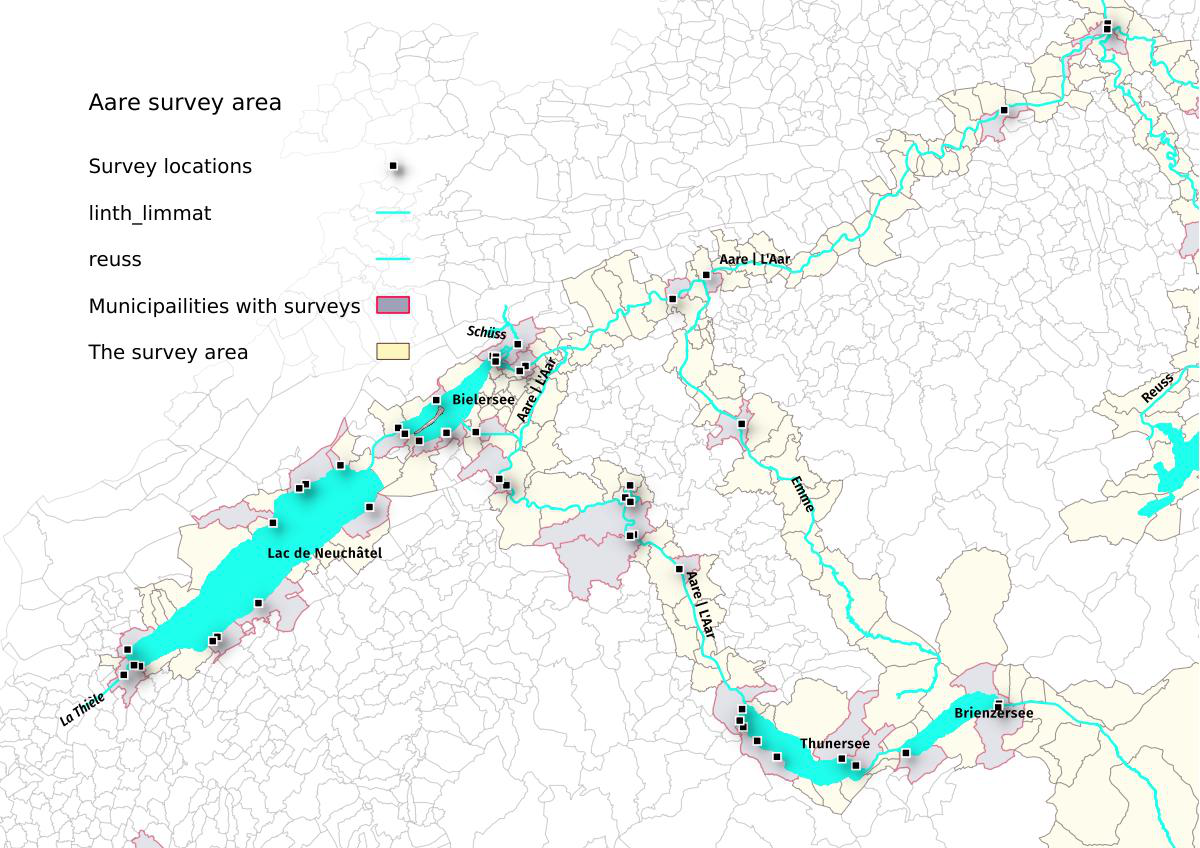

In [6]:
output = io.BytesIO()
bassin_map.save(output, format='PNG')
encoded_string = base64.b64encode(output.getvalue()).decode()

html = '<img src="data:image/png;base64,{}"/>'.format(encoded_string)
IPython.display.HTML(html)

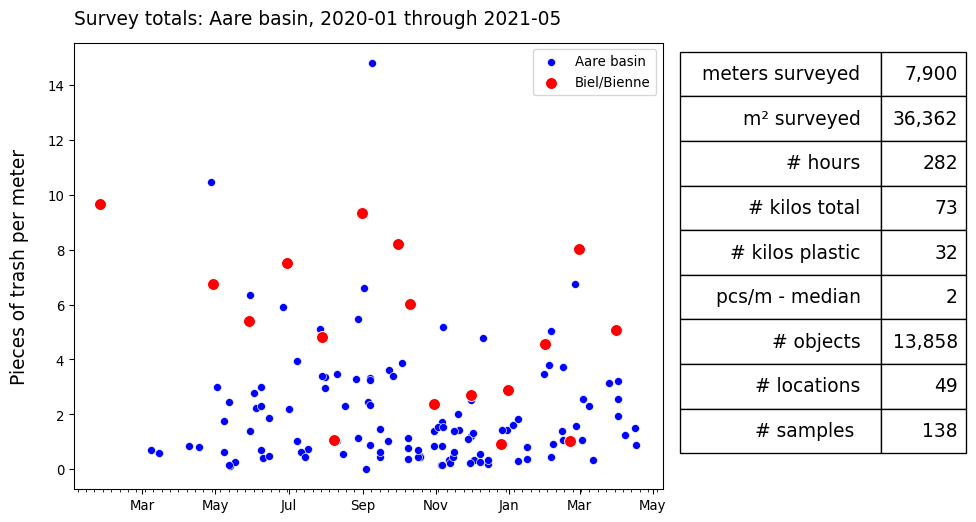

In [7]:
months = mdates.MonthLocator(interval=1)
months_fmt = mdates.DateFormatter('%b')
days = mdates.DayLocator(interval=7)

table_vals = [math.ceil(x) for x in rb_dims_sum.values]
table_str_vals = ['{:,}'.format(x) for x in table_vals]
table_data = list(zip(rb_dims_sum.index,table_str_vals ))

fig = plt.figure(figsize=(12,6), dpi=96)
gs = GridSpec(1, 12, figure=fig, wspace=.3, hspace=.3, top=.9)

axone = fig.add_subplot(gs[:, :8])
# axone = axs[0]
axtwo = fig.add_subplot(gs[:, 8:])
# axone=axs[0]
# axtwo=axs[1]

sns.scatterplot(data=dts, x='date', y='pcs_m', color='b', label=F"{level_names[2]}", ax=axone)
sns.scatterplot(data=the_city, x='date', y='pcs_m', color='r', s=80, label=levels['city'], ax=axone)

axone.set_xlabel("")
axone.set_ylabel("Pieces of trash per meter", **ck.xlab_k14)
axone.set_title(F"Survey totals: {level_names[2]}, {start_date[:7]} through {end_date[:7]}",  **ck.title_k14)
axone.xaxis.set_minor_locator(days)
axone.xaxis.set_major_formatter(months_fmt)

a_table = axtwo.table(table_data, loc='upper center', fontsize=14, colWidths=[.70,.30])
a_table.auto_set_font_size(False)
a_table.set_fontsize(14)

table_rows = a_table.get_celld()
# for cell in table_rows:
#     cell.facecolor = 'blue'
cellDict = a_table.get_celld()
for i in range(0,2):
    cellDict[(0,i)].set_height(.1)
    for j in range(1,len(table_data)):
        cellDict[(j,i)].set_height(.1)

axtwo.grid(False)
axtwo.axis('off')

plt.show()
plt.close()

In [8]:
section_header = F"[top](#top)\n### <a id='communesummary'></a><span style='color:#008891'>Summary of results {levels['city']}</span>"
md(section_header)

[top](#top)
### <a id='communesummary'></a><span style='color:#008891'>Summary of results Biel/Bienne</span>

In [9]:
summary = F"""1. Number of surveys: {int(biel_dims_sum['loc_date'])}\n
2. Number of locations surveyed: {int(biel_dims_sum['locations'])}\n 
3. Total meters of shoreline surveyed: {int(biel_dims_sum['length'])}
4. Total surface area: {int(biel_dims_sum['area'])}m²
5. Total time in hours: {int(biel_dims_sum['time_minutes']/60)}
6. Pieces of trash per meter of shoreline: {round(biel_dims_sum['pcs_m'],2)}
7. Number of objects removed: {int(biel_dims_sum['quantity'])}
8. Kilograms removed : {round(biel_dims_sum['total_w'], 2)}
9. Kilograms of plastic removed: {round((biel_dims_sum['mac_plast_w']/1000), 2)}
"""
md(summary)

1. Number of surveys: 17

2. Number of locations surveyed: 3
 
3. Total meters of shoreline surveyed: 697
4. Total surface area: 5092m²
5. Total time in hours: 47
6. Pieces of trash per meter of shoreline: 5.06
7. Number of objects removed: 3309
8. Kilograms removed : 8.2
9. Kilograms of plastic removed: 4.0


In [10]:
section_header = F"#### <span style='color:#008891'>Survey locations {levels['city']}</span>"
md(section_header)

#### <span style='color:#008891'>Survey locations Biel/Bienne</span>


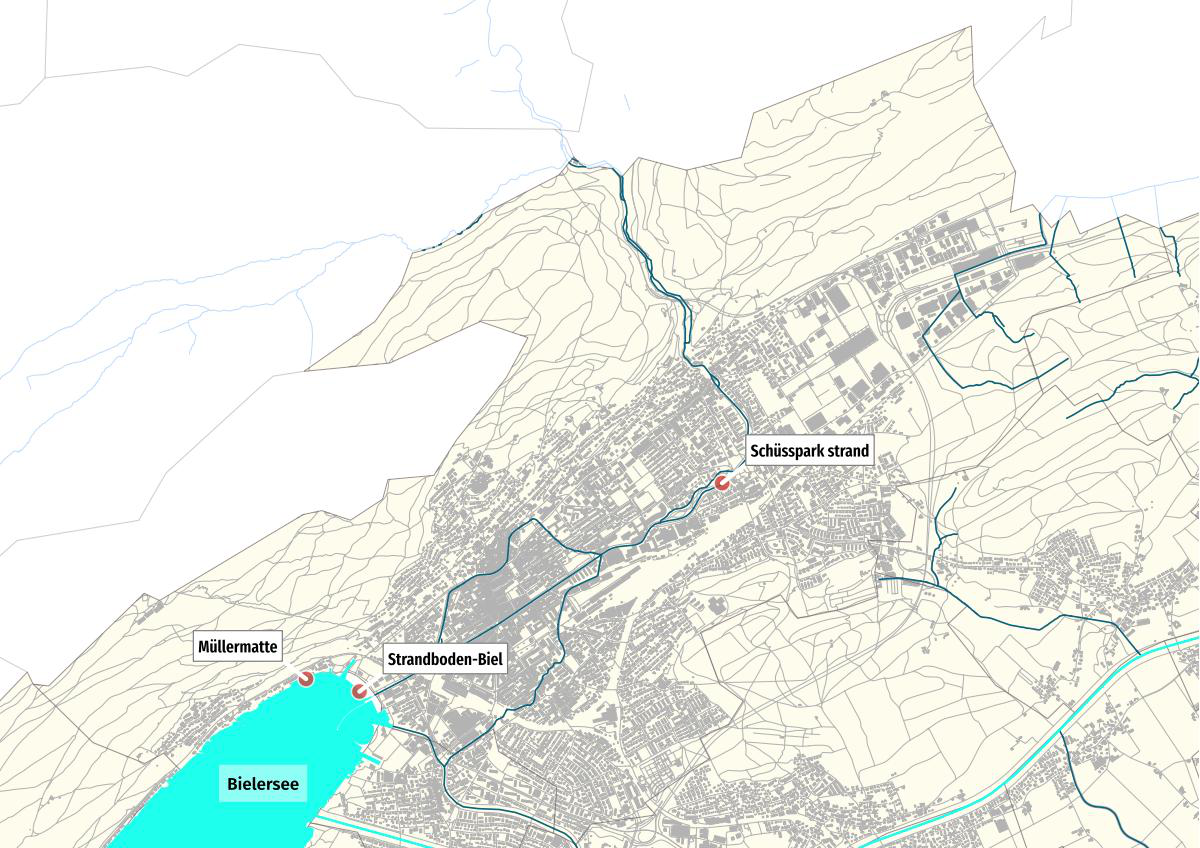

In [11]:
output = io.BytesIO()
city_map.save(output, format='PNG')
encoded_string = base64.b64encode(output.getvalue()).decode()

html = '<img src="data:image/png;base64,{}"/>'.format(encoded_string)
IPython.display.HTML(html)

[top](#top)
<a id='combinedtopten'></a>
### <span style='color:#008891'>The 10 items found in the greatest quantities: pieces of trash per meter</span>

In [12]:
add_feature_top_ten = f_n_samps > 1

astring = "The survey results vary from region to region. If your municipality shows higher results for a particular object or group you may be close to the source or a zone of accumulation."

if add_feature_top_ten:
    an_alert = F"The top ten items from {levels['city']} and {level_names[1]}.\n {astring}"
else:
    an_alert = F"The top ten items from {levels['city']} and the {level_names[2]} bassin.\n {astring}"
md(an_alert)

The top ten items from Biel/Bienne and Bielersee.
 The survey results vary from region to region. If your municipality shows higher results for a particular object or group you may be close to the source or a zone of accumulation.

In [13]:
# get the top ten at each aggregation level
the_top_ten_combined = set([*city_t_ten.index[:10], *f_t_ten.index[:10], *rb_t_ten.index[:10], *a_t_ten.index[:10]])

#kwargs for aggregator
these_kwargs = dict(
    group='code',
    dailycols={'pcs_m':'sum', 'quantity':'sum'}, 
    agg_cols={"pcs_m":"mean"},
    national=True,
    col_name="All river bassins",
    level_names=level_names,
    daily=True)
    
# the top ten from the city 
t_ten_city = ac.agg_pcs_m_by_city_feature_basin_all(a_data[(a_data.code.isin(city_t_ten.index[:10] ))], levels, **these_kwargs)

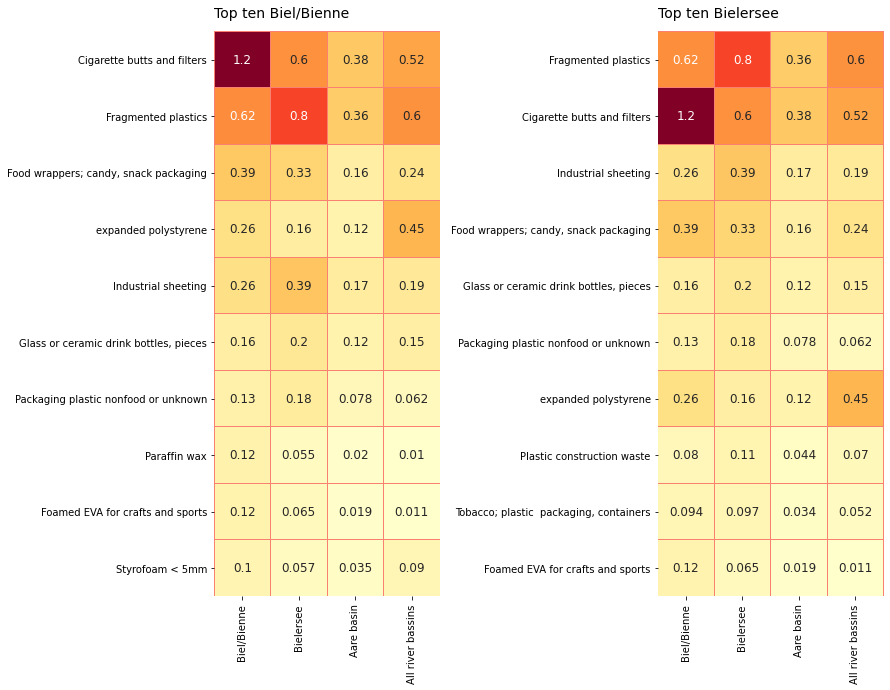

In [14]:
# reindex to description
t_ten_city['item'] = t_ten_city.index.map(lambda x: code_description_map[x])
code_t_ten = t_ten_city.set_index('item', drop=True)
code_t_ten.sort_values(by=levels['city'], ascending=False, inplace=True)
# code_t_ten.rename(columns=level_names, inplace=True)

# compare to either the closest water feature or the river bassin
if add_feature_top_ten:
    second_chart = ac.agg_pcs_m_by_city_feature_basin_all(a_data[(a_data.code.isin(f_t_ten.index[:10]))], levels, **these_kwargs)
    second_chart['item'] = second_chart.index.map(lambda x: code_description_map[x])
    second_chart = second_chart.set_index('item', drop=True)
   
    second_chart.sort_values(by=level_names[1], ascending=False, inplace=True)
#     second_chart.rename(columns=level_names, inplace=True)
    second_chart_title = level_names[1]
else:
    second_chart = ac.agg_pcs_m_by_city_feature_basin_all(a_data[(a_data.code.isin(rb_t_ten.index[:10]))], levels, **these_kwargs)
    second_chart['item'] = second_chart.index.map(lambda x: code_description_map[x])
    second_chart = second_chart.set_index('item', drop=True)
    
    second_chart.sort_values(by=level_names[2], ascending=False, inplace=True)
  
    second_chart_title = F"{level_names[2]}"


# chart that
fig = plt.figure(figsize=(12,14))
gs = GridSpec(12, 3, figure=fig, wspace=.5, hspace=.5, top=.9, width_ratios=[.45,.1,.45])

axone = fig.add_subplot(gs[:, 0])
# axone = axs[0]
axtwo = fig.add_subplot(gs[:, 2])

sns.heatmap(code_t_ten, ax=axone, cmap='YlOrRd', annot=True, annot_kws={"fontsize":12}, fmt='.2',  square=True, cbar=False, linewidth=.05, linecolor='salmon')
axone.set_title(F"Top ten {levels['city']}", **ck.title_k14)
# axone.set_xlabel("Combined top ten pcs/m", **ck.label_r14)
# axone.tick_params(**ck.xlabels_top, **ck.no_xticks)
axone.set_ylabel("")

sns.heatmap(second_chart, ax=axtwo, cmap='YlOrRd', annot=True, annot_kws={"fontsize":12}, fmt='.2',  square=True, cbar=False, linewidth=.05, linecolor='salmon')
axtwo.set_title(F"Top ten {second_chart_title}", **ck.title_k14)
# axtwo.set_xlabel("Combined top ten pcs/m", **ck.label_r14)
# axtwo.tick_params(**ck.xlabels_top, **ck.no_xticks)
axtwo.set_ylabel("")

plt.setp(axone.get_xticklabels(), rotation=90)
plt.setp(axtwo.get_xticklabels(), rotation=90)

plt.show()
plt.close()

[top](#top)
<a id='matanduse'></a><a id='scope'></a>
### <span style='color:#008891'>Material type and Utility: percent of total objects collected</span>

**Material type** The material type is determined based on the classification in the the guide on monitoring marine litter. 

**Utility** The utility type is based on the utilisation of the object prior to it being discarded. Objects are placed into to one of the 260 categories. Those categories are grouped according to utilisation.

For example, a piece of plastic would be placed into the category 'Fragmented plastics', depending on its size. However, a piece of plastic that was once a bucket
and we know this because we are familiar with either the brand or the product, is placed in a code for buckets.

In the tables below each column is the results for that city/lake/river-bassin. The darker the color the more of a problem that group of objects is in relation to all other objects found at that city/lake/river bassin.

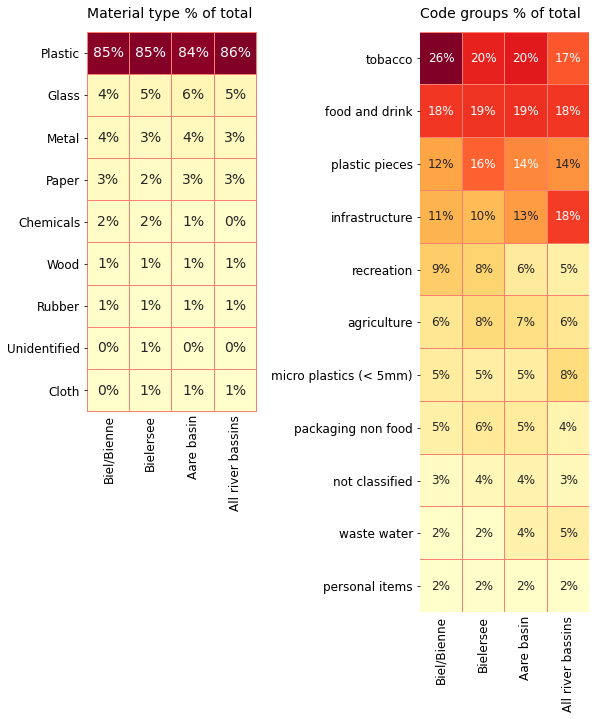

In [15]:
column_denominators = [
    biel.quantity.sum(),
    trb[trb.water_name_slug == levels['water_name_slug']].quantity.sum(),
    trb.quantity.sum(),
    a_data.quantity.sum()
]

code_group_kwargs = dict(
    group='groupname',
    dailycols={'pcs_m':'sum', 'quantity':'sum'},
    agg_cols={'quantity':'sum'},
    national=True,
    col_name="All river bassins",
    daily=False,
    level_names=level_names
)

code_groups_pcs_m = ac.agg_pcs_m_by_city_feature_basin_all(a_data, levels,**code_group_kwargs)
code_groups_pcs_m.sort_values(by=levels['city'], ascending=False, inplace=True)
  
cgroup_p_t = code_groups_pcs_m.divide(column_denominators).round(3)

material_group_kwargs = dict(
    group='material',
    dailycols={'pcs_m':'sum', 'quantity':'sum'},
    agg_cols={'quantity':'sum'},
    national=True,
    col_name="All river bassins",
    daily=False,
    level_names=level_names
)

material_groups_pcs_m = ac.agg_pcs_m_by_city_feature_basin_all(a_data, levels, **material_group_kwargs)
material_groups_pcs_m.sort_values(by=levels['city'], ascending=False, inplace=True)

mat_g_h = material_groups_pcs_m.divide(column_denominators).round(3)


fig = plt.figure(figsize=(9,14))

gs = GridSpec(12, 3, figure=fig, wspace=.5, hspace=.5, top=.9, width_ratios=[.45,.1,.45])


axone = fig.add_subplot(gs[0:6, 0])
sns.heatmap(mat_g_h, ax=axone, cmap='YlOrRd', annot=True, annot_kws={"fontsize":14}, fmt='.0%', cbar=False, linewidth=.01, linecolor='salmon')
axone.set_title("Material type % of total", **ck.title_k14)
axone.tick_params(**ck.no_xticks)
axone.set_ylabel("")

axtwo = fig.add_subplot(gs[0:9, 2])
sns.heatmap(cgroup_p_t, ax=axtwo, cmap='YlOrRd', annot=True, annot_kws={"fontsize":12}, fmt='.0%',   cbar=False, linewidth=.01, linecolor='salmon')

axtwo.set_title("Code groups % of total", **ck.title_k14)
axtwo.tick_params(**ck.no_xticks)
axtwo.set_ylabel("")

plt.setp(axtwo.get_xticklabels(), rotation=90, fontsize=12)
plt.setp(axtwo.get_yticklabels(), rotation=0, fontsize=12)

plt.setp(axone.get_xticklabels(), rotation=90, fontsize=12)
plt.setp(axone.get_yticklabels(), rotation=0, fontsize=12)
plt.show()

### <span style='color:#008891'>How often are these objects found?</span>

In [16]:
add_feature_top_ten = f_n_samps > 1
city_fail_rate = c_n_samps > 1



astring = "Some objects are found often and in elevated quantities, others are found often and in small quantities and some times objects are found less often but in large quantities. Knowing the diffference can help find the sources."

if add_feature_top_ten:
    first_level = levels['city']
    second_level = levels['water_name_slug']
    fail_codes=list(set([*city_t_ten.index[:10],*f_t_ten.index[:10]]))
    
else:
    first_level = levels['city']
    second_level = levels['river_bassin']
    fail_codes=list(set([*city_t_ten.index[:10],*rb_t_ten.index[:10]]))
    
an_alert = F"Frequency of occurence from {first_level} and the {level_names[2]}.\n {astring}"
md(an_alert)

Frequency of occurence from Biel/Bienne and the Aare basin.
 Some objects are found often and in elevated quantities, others are found often and in small quantities and some times objects are found less often but in large quantities. Knowing the diffference can help find the sources.

In [17]:
# this is a convenience function for the abundance class
# the fail rate needs to be recalculated at each aggregation level
fail_rates_df = ac.agg_fail_rate_by_city_feature_basin_all(a_data, levels, group='code')

a_fail_rate = 60

d = fail_rates_df[(fail_rates_df.iloc[:, :] > (a_fail_rate/100)).any(axis=1)]

# top ten from both levels and > 50% fail raite
frst_level_fail = d.loc[d.index.isin(fail_codes)][first_level].sort_values(ascending=False)[:10].index


objs_both = frst_level_fail
objs_fail_not_t_ten = list(set(fail_codes)-set(frst_level_fail))
objs_not = [x for x in d.index if x not in fail_codes]

In [18]:
pcs_d_both = a_data[(a_data.quantity > 0)&(a_data.city == levels['city'])&(a_data.code.isin(objs_both))].groupby('loc_date').pcs_m.sum().agg(['mean', 'min', 'max'])
found_fail = [F"<br/>{str((i+1))}. {x}" for i,x in enumerate([code_description_map[x] for x in objs_both])]
found_fail = ' '.join(found_fail )
md(F"""**Objects found in at least {a_fail_rate}% of surveys and in the top ten**<br>
Combined they had an average pieces per meter per survey of {round(pcs_d_both['mean'], 2)}, a min of {round(pcs_d_both['min'], 2)} and max of {round(pcs_d_both['max'], 2)}<br>
{found_fail}\n
""")

**Objects found in at least 60% of surveys and in the top ten**<br>
Combined they had an average pieces per meter per survey of 3.32, a min of 0.37 and max of 6.76<br>
<br/>1. Fragmented plastics <br/>2. Cigarette butts and filters <br/>3. Food wrappers; candy, snack packaging <br/>4. expanded polystyrene <br/>5. Industrial sheeting <br/>6. Tobacco; plastic  packaging, containers <br/>7. Plastic construction waste <br/>8. Glass or ceramic drink bottles, pieces <br/>9. Packaging plastic nonfood or unknown <br/>10. Styrofoam < 5mm



In [19]:
if len(objs_fail_not_t_ten) > 0:
    pcs_d_fail = a_data[(a_data.quantity > 0)&(a_data.code.isin(objs_fail_not_t_ten))].groupby('loc_date').pcs_m.sum().agg(['mean', 'min', 'max'])
    not_found_fail = [F"<br/>{str((i+1))}. {x}" for i,x in enumerate([code_description_map[x] for x in objs_fail_not_t_ten])]
    not_found_fail = ' '.join(not_found_fail)
    a_string = F"""**Objects found in less than {a_fail_rate}% of the surveys and in the top ten**<br>Combined they had an average pieces per meter per survey of {round(pcs_d_fail['mean'], 2)}, a min of {round(pcs_d_fail['min'], 2)} and max of {round(pcs_d_fail['max'], 2)}
    <br>{not_found_fail}\n
    """   
else:
    a_string="\n"

md(a_string)

**Objects found in less than 60% of the surveys and in the top ten**<br>Combined they had an average pieces per meter per survey of 0.11, a min of 0.01 and max of 0.86
    <br><br/>1. Foamed EVA for crafts and sports <br/>2. Paraffin wax

    

In [20]:
if len(objs_not) > 0:
    pcs_d_pcs = a_data[(a_data.quantity > 0)&(a_data.city == levels['city'])&(a_data.code.isin(objs_not))].groupby('loc_date').pcs_m.sum().agg(['mean', 'min', 'max'])
    fail_not_found = [F"<br/>{str((i+1))}. {x}" for i,x in enumerate([code_description_map[x] for x in objs_not])]
    fail_not_found = ' '.join(fail_not_found )
    astring = F"""**Objects found in at least {a_fail_rate}% of the surveys and NOT in the top ten**<br>Combined they had an average pieces per meter per survey of {round(pcs_d_pcs['mean'], 2)}, a min of {round(pcs_d_pcs['min'], 2)} and max of {round(pcs_d_pcs['max'], 2)}
    <br>{fail_not_found}\n    
    """
else:
    astring = ""

md(astring)

**Objects found in at least 60% of the surveys and NOT in the top ten**<br>Combined they had an average pieces per meter per survey of 0.66, a min of 0.04 and max of 1.38
    <br><br/>1. Food containers single use foamed or plastic <br/>2. Plastic fragments angular <5mm <br/>3. Industrial pellets (nurdles) <br/>4. Foil wrappers, aluminum foil <br/>5. Metal bottle caps, lids & pull tabs from cans <br/>6. Other medical items (swabs, bandaging, adhesive plaster) <br/>7. Lid/cap rings from plastic bottles/containers <br/>8. Lollypop sticks <br/>9. Straws and stirrers <br/>10. String < 1cm <br/>11. Foams not expanded polystyrene <br/>12. Fireworks; rocket caps, exploded parts & packaging <br/>13. Cotton bud/swab sticks
    
    

### <span style="color:#008891">More information</span>

Contact hammerdirt.ch for any questions about the content of this report. If you would like a report for your municipality contact the Swiss federal office for the environment: Municipal waste section.

In [21]:
author = "roger@hammerdirt.ch"
my_message = "Statistics is fun when you do it outside"
md(F"""### <span style="color:#000099">Have a great day</span>
**This project was made possible by the Swiss federal office for the environment.**<br>
This document originates from https://github.com/hammerdirt-analyst/iqals all copyrights apply.<br>
*{author}* pushed the run button on {today}.
""")

### <span style="color:#000099">Have a great day</span>
**This project was made possible by the Swiss federal office for the environment.**<br>
This document originates from https://github.com/hammerdirt-analyst/iqals all copyrights apply.<br>
*roger@hammerdirt.ch* pushed the run button on 2021-05-18.


[top](#top)
<a id=annex></a>
### <span style="color:#008891">Annex</span>

#### Survey locations

In [22]:
city_beaches

,latitude,longitude,lake/river,bfsnum
location,,,,
Müllermatte,47.133339,7.227907,Bielersee,371
Schüsspark strand,47.146500,7.268620,Schüss,371
Strandboden-Biel,47.132510,7.233142,Bielersee,371


#### Inventory of all items removed

In [23]:
pd.set_option('display.max_rows', None)
complete_inventory.sort_values(by='quantity', ascending=False)

,,,,quantity,pcs_m
item,code,material,groupname,,
Cigarette butts and filters,G27,Plastic,tobacco,781,1.150
Fragmented plastics,Gfrags,Plastic,plastic pieces,403,0.500
"Food wrappers; candy, snack packaging",G30,Plastic,food and drink,253,0.415
Industrial sheeting,G67,Plastic,agriculture,166,0.255
expanded polystyrene,Gfoam,Plastic,infrastructure,163,0.200
Packaging plastic nonfood or unknown,G941,Plastic,packaging non food,95,0.140
"Glass or ceramic drink bottles, pieces",G200,Glass,food and drink,94,0.080
Foamed EVA for crafts and sports,G940,Plastic,recreation,84,0.090
Paraffin wax,G213,Chemicals,recreation,75,0.145
